<img src="../images/aeropython_logo.png" alt="AeroPython" style="width: 300px;"/>

# Clase 5b: Mecánica con SymPy

_Si SymPy te ha parecido hasta ahora un CAS decente e incluso interesante (nada como tener los resultados en $\LaTeX$ incrustados en el notebook y la sintaxis de Python para hacer cálculo simbólico) entonces espera a ver el paquete `mechanics`. Con él, podremos manipular velocidades y aceleraciones de sólidos expresadas en distintos sistemas de referencia con una facilidad impresionante._

_Tienes disponible la documentación de `mechanics` en http://docs.sympy.org/0.7.5/modules/physics/mechanics/index.html._

## Sistemas de referencia

El objeto primordial que vamos a manejar van a ser los sistemas de referencia. Podremos definir relaciones geométricas entre ellos y de esta forma las transformaciones de vectores entre un sistema y otro serán triviales.

In [1]:
from sympy import init_session
init_session(use_latex=True)

IPython console for SymPy 1.0 (Python 3.6.1-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


Todo lo que necesitamos está en `sympy.physics.mechanics`, incluyendo la clase `ReferenceFrame`. Nada más crear un sistema de referencia podemos acceder a sus versores unitarios: `x`, `y` y `z`.

http://docs.sympy.org/0.7.5/modules/physics/vector/vectors.html

In [2]:
from sympy.physics.mechanics import ReferenceFrame

In [3]:
A = ReferenceFrame("A")
A.x

Y para definir vectores solo tenemos que **multiplicar cada componente por su versor**:

In [4]:
2 * A.x - 1 * A.y

De ahora en adelante, para trabajar como si nos enfrentáramos a un problema de la escuela, vamos a hacer dos cosas:

* Definir un sistema inercial $1$ del que partir, para así poder referir todos los demás sistemas a él.
* Que los versores de ese sistema sean $i, j, k$.

In [5]:
A = ReferenceFrame("1", latexs=['\mathbf{i}', '\mathbf{j}', '\mathbf{k}'])
A.x + A.y + A.z

Y para no tener que hacerlo siempre, un pequeño truco de magia:

In [6]:
# Definimos nuestra propia clase para que los versores sean IJK
class IJKReferenceFrame(ReferenceFrame):
    def __init__(self, name):
        super().__init__(name, latexs=['\mathbf{%s}_{%s}' % (idx, name) for idx in ("i", "j", "k")])
        self.i = self.x
        self.j = self.y
        self.k = self.z

In [7]:
A = IJKReferenceFrame("1")
A.i + A.j + A.k

### Álgebra vectorial

Nuestros vectores funcionan también con símbolos, y podemos realizar las operaciones de producto escalar y producto vectorial con ellos.

In [8]:
R, V = symbols('R, V', positive=True)
r1 = R * (A.x + A.y + A.z)
v1 = V * (A.x - 2 * A.z)

In [9]:
r1

In [10]:
v1

In [11]:
from sympy.physics.mechanics import dot, cross

In [12]:
r1.dot(v1)
dot(r1, v1)
r1 & v1

In [14]:
r1.cross(v1)
cross(r1, v1)
r1 ^ v1

Podemos hallar también la norma de los vectores con su método `magnitude` e incluso normalizarlos con `normalize`:

In [15]:
(r1 ^ v1).magnitude()

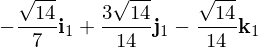

In [16]:
(r1 ^ v1).normalize()

##### Ejercicio

Usando directamente la fórmula para la derivada en ejes móviles:

$$\left(\frac{\operatorname{d}\!\mathbf{a}}{\operatorname{d}\!t}\right)_1 = \left(\frac{\operatorname{d}\!\mathbf{a}}{\operatorname{d}\!t}\right)_0 + \mathbf{\omega}_{01}\! \times \mathbf{a}$$

Calcula la derivada del vector de posición $R \mathbf{i}_0$, siendo $A_0$ un sistema de referencia que gira respecto al inercial con velocidad angular $\mathbf{\omega}_{01}=\Omega \mathbf{k}_0$. **¿Cuál es el módulo de la derivada?**

In [17]:
R, Omega = symbols('R, Omega', positive=True)
A0 = IJKReferenceFrame('0')

In [18]:
a = R * A0.i
a

In [19]:
omega01 = Omega * A0.k
omega01

In [20]:
da = omega01 ^ a
da

In [21]:
da.magnitude()

<div class="alert alert-warning">Si no especificaste `positive=True` vas a ver algo como $\sqrt{\Omega^2 R^2}$. Debería haber una forma de simplificar esta expresión _a posteriori_, pero de momento no funciona del todo bien. Preparando este notebook nos hemos dado cuenta y ya les hemos avisado :) https://github.com/sympy/sympy/issues/8326
</div>

### Movimiento relativo

¿A quién no le gusta multiplicar matrices de rotación? Para esa minoría que lo detesta, existe SymPy. Para ello debemos especificar la orientación de nuestros sistemas de referencia usando el método `orient`, y recuperaremos la matriz de cosenos directores usando el método `dcm`.

In [22]:
A1 = IJKReferenceFrame("1")
A0 = IJKReferenceFrame("0")

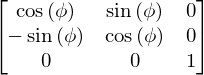

In [23]:
phi = symbols('phi')
A0.orient(A1, 'Axis', [phi, A1.z])  # Rotación phi alrededor del eje A1.z
A0.dcm(A1)  # "Direct Cosine Matrix"

Usando el argumento `Axis` hemos especificado que rotamos el sistema un ángulo especificado alrededor de un eje. Otros métodos son:

* `Body`: se especifican los tres ángulos de Euler.
* `Space`: igual que `Body`, pero las rotaciones se aplican en orden inverso.
* `Quaternion`: utilizando cuaternios, rotación alrededor de un vector unitario $\lambda$ una cantidad $\theta$.

<div class="alert alert-success">¿Qué es lo bueno de usar uno de estos métodos? ¡Que **siempre** tenemos la transformación bien definida! Es imposible meter "a capón" una matriz de rotación que sea incorrecta o absurda.</div>

#### Diferente sistema de referencia

Para expresar un vector en otro sistema de referencia, no hay más que usar los métodos `express` o `to_matrix`:

In [24]:
A0.x.express(A1)

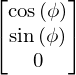

In [25]:
A0.x.to_matrix(A1)

#### Símbolos dinámicos

Si queremos especificar que un símbolo puede variar con el tiempo, hay que usar la función `dynamicsymbols`:

In [26]:
from sympy.physics.mechanics import dynamicsymbols

In [27]:
alpha = dynamicsymbols('alpha')
alpha

Y pedir su derivada con el método `diff`:

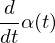

In [28]:
alpha.diff()

##### Ejercicio

![Sistemas de ejes asociados a la pala](../images/ejes_pala.jpg)

(Sacado de Cuerva et al. "Teoría de los Helicópteros")

**Obtener la matriz de rotación de la pala $B$ respecto a los ejes $A1$.**

In [29]:
A = IJKReferenceFrame("A")

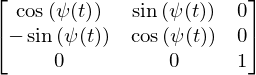

In [30]:
A1 = IJKReferenceFrame("A1")
psi = dynamicsymbols('psi')
A1.orient(A, 'Axis', [psi, A.z])
A1.dcm(A)  # T_{A1A}

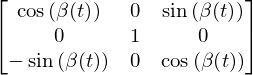

In [31]:
A2 = IJKReferenceFrame("A2")
beta = dynamicsymbols('beta')
A2.orient(A1, 'Axis', [beta, -A1.y])
A2.dcm(A1)  # T_{A2A1}

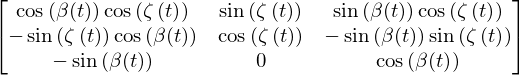

In [32]:
A3 = IJKReferenceFrame("A3")
zeta = dynamicsymbols('zeta')
A3.orient(A2, 'Axis', [zeta, A2.z])
A3.dcm(A1)  # T_{A3A1}

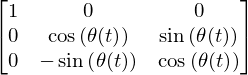

In [33]:
B = IJKReferenceFrame("B")
theta = dynamicsymbols('theta')
B.orient(A3, 'Axis', [theta, A3.x])
B.dcm(A3)  # T_{BA3}

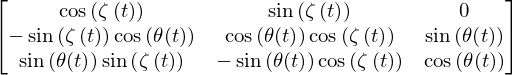

In [34]:
B.dcm(A2)

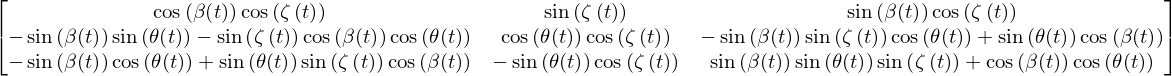

In [35]:
B.dcm(A1)

#### Velocidad angular

También podemos hallar la velocidad angular de un sistema respecto a otro usando el método `ang_vel_in`:

In [36]:
B.ang_vel_in(A2)

In [37]:
B.ang_vel_in(A)

In [38]:
B.ang_vel_in(A).express(A)

### Derivada en ejes móviles

Hacer una derivada con la fórmula lo hace cualquiera, pero SymPy puede encargarse automáticamente.

In [39]:
v1 = A1.x
v1

In [40]:
#v1.diff(dynamicsymbols._t, A2)
dv1 = v1.diff(symbols('t'), A)
dv1

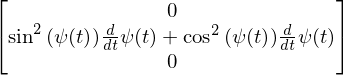

In [41]:
dv1.to_matrix(A1)

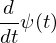

In [42]:
(dv1 & A1.j).simplify()

### Puntos, velocidades y la rueda que no desliza

El último paso que nos queda para completar la cinemática es la posibilidad de definir puntos en sólidos y aplicar su campo de velocidades. SymPy también permite esto, y para ello no tenemos más que importar la clase `Point`.

In [43]:
from sympy.physics.mechanics import Point

In [44]:
O = Point("O")

Para trabajar como lo haríamos en la escuela, vamos a especificar que $O$ es el origen de $A$, y para eso vamos a imponer que su velocidad es cero con el método `set_vel`:

In [45]:
O.set_vel(A, 0)

Para definir nuevos puntos, podemos utilizar el método `locate_new`:

In [46]:
e_b = symbols('e_b')
E_b = O.locatenew('E_b', e_b * A1.x)

Y para obtener vectores de un punto a otro, el método `pos_from`:

In [47]:
E_b.pos_from(O)

<div class="alert alert-info">La notación de este paquete está influenciada por el libro Kane, T. R. & Levinson, D. A. "Dynamics, Theory and Applications". Es ligeramente distinto a como estudiamos nosotros en la escuela, pero ¡están abiertos a que les hagamos cualquier tipo de sugerencia! https://github.com/sympy/sympy/issues/2584#issuecomment-31552654</div>

Por último, el **campo de velocidades de un sólido rígido** se formula usando el método `v2pt_theory`.

$$v^P_A = v^O_A + \omega_{A_1 A} \times \mathbf{OP}$$

Este método pertenece *al punto del cual queremos conocer la velocidad* y recibe tres parámetros:

* `O`, punto de velocidad conocida respecto a A
* `A`, sistema de referencia donde queremos calcular la velocidad
* `A1`, sistema de referencia donde están fijos ambos puntos (_sistema de arrastre_)


Por tanto, para hallar la velocidad del punto que acabamos de crear:

In [48]:
E_b.v2pt_theory(O, A, A1)

##### Ejercicio

![Disco que rueda](../images/disco.png)

(Apuntes del profesor Dr. Óscar López Rebollal)

**¡Halla la velocidad y la aceleración de $P$!**

In [49]:
# Creamos nuestros sistemas de referencia
A1 = IJKReferenceFrame('1')
A0 = IJKReferenceFrame('0')
A2 = IJKReferenceFrame('2')

In [50]:
# Creamos los símbolos dinámicos necesarios
xi, theta = dynamicsymbols('xi, theta')
xi, theta

In [51]:
# Orientamos los sistemas de referencia
A0.orient(A1, 'Axis', [0, A1.k])  # A0 no gira respecto a A1
A2.orient(A0, 'Axis', [theta, A0.k])

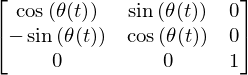

In [52]:
A2.dcm(A1)

In [53]:
# Creamos el punto C, centro del disco, y especificamos su velocidad
# respecto a A1
C = Point('C')
C.set_vel(A1, xi.diff() * A1.x)

In [54]:
# Localizamos el punto P, punto fijo del disco, respecto a C, en
# el sistema A2 (que gira solidariamente con el disco)
R = symbols('R')
P = C.locatenew('P', -R * A2.j)
P.pos_from(C)

In [55]:
# Hallamos la velocidad de P en A1, expresada en A0
# ¡Con esta llamada ya estamos diciendo que C y P son fijos en A2!
P.v2pt_theory(C, A1, A2).express(A0)

**Misión cumplida :)**

---

_Hemos hecho un repaso bastante profundo de las posibilidades del paquete `mechanics` de SymPy. Nos hemos dejado algunas cosas en el tintero pero no demasiadas: esta funcionalidad aún se está expandiendo y necesita pulir algunos detalles._

**Referencias**

* Capítulo de **aeromecánica** del libro de Cuerva y otros http://nbviewer.ipython.org/gist/Juanlu001/7711865
* Estabilidad longitudinal de un Boeing 747 http://nbviewer.ipython.org/github/AlexS12/Mecanica_Vuelo/blob/master/MVII_MatrizSistema.ipynb

_¿Serás tú el siguiente que publique un notebook usando SymPy? ;)_

Si te ha gustado esta clase:

<a href="https://twitter.com/share" class="twitter-share-button" data-url="https://github.com/AeroPython/Curso_AeroPython" data-text="Aprendiendo Python con" data-via="pybonacci" data-size="large" data-hashtags="AeroPython">Tweet</a>
<script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>

---

#### <h4 align="right">¡Síguenos en Twitter!

###### <a href="https://twitter.com/Pybonacci" class="twitter-follow-button" data-show-count="false">Follow @Pybonacci</a> <script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>  <a href="https://twitter.com/Alex__S12" class="twitter-follow-button" data-show-count="false" align="right";>Follow @Alex__S12</a> <script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>  <a href="https://twitter.com/newlawrence" class="twitter-follow-button" data-show-count="false" align="right";>Follow @newlawrence</a> <script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>

##### <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es"><img alt="Licencia Creative Commons" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Curso AeroPython</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Juan Luis Cano Rodriguez y Alejandro Sáez Mollejo</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es">Licencia Creative Commons Atribución 4.0 Internacional</a>.

##### <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/juanluiscanor" data-format="inline" data-related="false"></script> <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/alejandrosaezm" data-format="inline" data-related="false"></script>

---
_Las siguientes celdas contienen configuración del Notebook_

_Para visualizar y utlizar los enlaces a Twitter el notebook debe ejecutarse como [seguro](http://ipython.org/ipython-doc/dev/notebook/security.html)_

    File > Trusted Notebook

In [2]:
%%html
<a href="https://twitter.com/Pybonacci" class="twitter-follow-button" data-show-count="false">Follow @Pybonacci</a>
<script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>

In [1]:
# Esta celda da el estilo al notebook
from IPython.core.display import HTML
css_file = '../styles/aeropython.css'
HTML(open(css_file, "r").read())